In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
import utils as u
u.check_python_version()
u.check_virtual_memory()

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
Virtual memory usage - total: 31 GB / available: 26 GB / percent used: 16.1 %


In [2]:
# Open a dataset with monthly data
ds = xr.open_dataset(
    'snowc.mon.noaaV2c_185101_201412_2.0x1.75.nc'
)
ds

<xarray.Dataset>
Dimensions:    (lat: 94, lon: 192, nbnds: 2, time: 1968)
Coordinates:
  * lat        (lat) float32 88.542 86.6531 84.7532 ... -86.6531 -88.542
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 354.375 356.25 358.125
  * time       (time) datetime64[ns] 1851-01-01 1851-02-01 ... 2014-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    snowc      (time, lat, lon) float32 ...
Attributes:
    Conventions:             CF-1.2
    title:                   4x Daily NOAA-CIRES 20th Century Reanalysis V2c
    platform:                Model
    institution:             NOAA ESRL Physical Sciences Division & CU/CIRES ...
    citation:                Compo,G.P. <http://www.esrl.noaa.gov/psd/people/...
    version:                 2c
    contact:                 esrl.psd.data@noaa.gov
    source:                  20CRv2c 2014, Ensemble Kalman Filter, ocean (spe...
    forcing_note:            Additional information on the exte

In [3]:
# Get the variable and perdiod
da = ds.snowc.sel(time=slice('1984', '2014'))
da

<xarray.DataArray 'snowc' (time: 372, lat: 94, lon: 192)>
[6713856 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * time     (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2014-12-01
Attributes:
    long_name:         Monthly Snow Cover at Surface
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             %
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid


## Spatial average

### Not weighted

In [4]:
clim = u.clim(da)
clim

<xarray.DataArray (lat: 94, lon: 192)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]])
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125

<IPython.core.display.Javascript object>


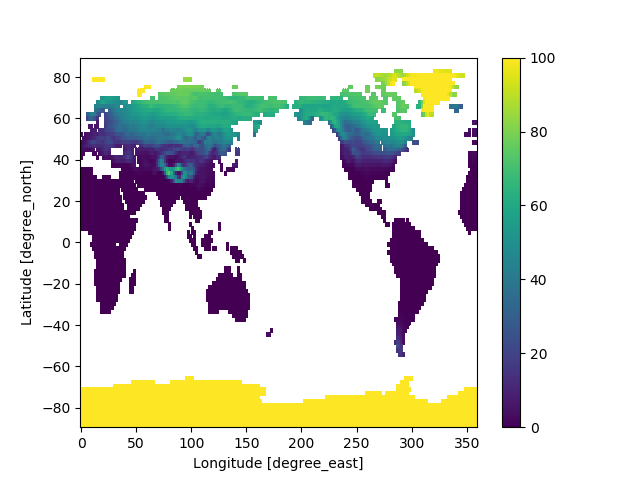

In [5]:
plt.figure()
clim.plot()

In [6]:
spatial_average_not_weighted = clim.mean()
spatial_average_not_weighted

<xarray.DataArray ()>
array(48.71303531)

### Compute the weights

In [6]:
weights = (clim*0 + np.cos(np.deg2rad(clim.lat))) / (clim*0 + np.cos(np.deg2rad(clim.lat))).sum()
weights

<xarray.DataArray (lat: 94, lon: 192)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [2.74807482e-05, 2.74807482e-05, 2.74807482e-05, ...,
        2.74807482e-05, 2.74807482e-05, 2.74807482e-05],
       [1.75443147e-05, 1.75443147e-05, 1.75443147e-05, ...,
        1.75443147e-05, 1.75443147e-05, 1.75443147e-05],
       [7.64632135e-06, 7.64632135e-06, 7.64632135e-06, ...,
        7.64632135e-06, 7.64632135e-06, 7.64632135e-06]])
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125

In [7]:
weights.sum()

<xarray.DataArray ()>
array(1.)

In [8]:
np.testing.assert_allclose(weights.sum().values, np.ones(1))

<IPython.core.display.Javascript object>


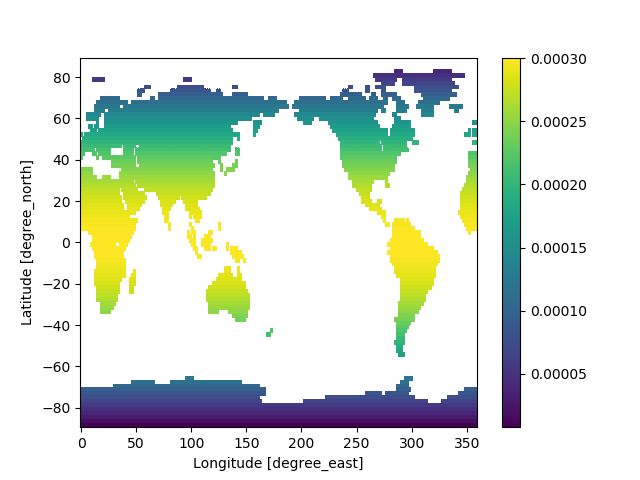

In [9]:
plt.figure()
weights.plot()

In [11]:
spatial_average_weighted = (clim * weights).sum()
spatial_average_weighted

<xarray.DataArray ()>
array(24.79210677)

# Check with utils.spatial_average

In [10]:
spatial_average = u.spatial_average(clim)
spatial_average

<xarray.DataArray ()>
array(24.79210677)

# Check with CDO

In [11]:
!cdo -fldmean snowc.timmean.noaaV2c_198401_201412_2.0x1.75.nc snowc.timmean-fldmean.noaaV2c_198401_201412_2.0x1.75.nc

cdo fldmean (Warning): Grid cell bounds not available, using constant grid cell area weights for variable time_bnds_2!
cdo fldmean:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo fldmean: Processed 18050 values from 2 variables over 1 timestep [0.02s 52MB]


In [12]:
spatial_average_cdo = xr.open_dataset('snowc.timmean-fldmean.noaaV2c_198401_201412_2.0x1.75.nc').snowc
spatial_average_cdo

<xarray.DataArray 'snowc' (time: 1, lat: 1, lon: 1)>
array([[[24.85302]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2014-06-16
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
Attributes:
    long_name:         Monthly Snow Cover at Surface
    units:             %
    cell_methods:      time: mean (monthly from 3-hourly values)
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [  0. 100.]

In [16]:
u.spatial_average(da.mean('time', skipna=False))

<xarray.DataArray ()>
array(24.855787, dtype=float32)

xgmc ?